# Introduction

In this project, we will be exploring the use Conformal Uncertainty Quantification (CUQ) in classification and segmentation. 

In particular, we are going to delve into the *SegFormer* model from HuggingFace, found here: https://huggingface.co/docs/transformers/v4.28.1/model_doc/segformer.

This is a pre-trained model which can be called on for semantic segmentation and/or classification. To this end, we will introduce the relevant datasets used to fine-tune the model and which we will be using to develop our intuition for CUQ.

The dataset used for classification fine-tuning is ImageNet-1k, which can be found here: https://huggingface.co/datasets/imagenet-1k

For semantic segmentation, we have the following:
1. ADE20K, https://groups.csail.mit.edu/vision/datasets/ADE20K/
2. Cityscapes, https://www.cityscapes-dataset.com/
3. COCO-stuff, https://github.com/nightrome/cocostuff

In the ImageNet-1k, we have 1000 object classes and contains 1,281,167 training images, 50,000 validation images and 100,000 test images. The images are in some snese "natural", i.e., images of everyday objects one might encounter throughout their life. This is a common dataset to test models against for this reason. 

In ADE20k, we have 27,574 images (25,574 for training and 2,000 for testing) spanning 365 different scenes, 707,868 unique objects from 3,688 categories, along with their WordNet definition and hierarchy, amd 193,238 annotated object parts and parts of parts.

In CityScapes, we have 30 classes and 25,000 annotated images, 5,000 with fine annotations and 20,000 with courser ones. The images are taken from 50 cities in daytime and throughout the year.

In COCO-Stuff, we have 164K images which have been hand-annotated for what is in each image. There are 80 thing classes, 91 stuff classes and 1 class 'unlabeled for a total of 172 classes of segmented objects.

We would like to test our pre-trained SegFormer model on these datasets and learn about this model's uncertainty in its classifications and segmentations.

# General Pipeline

In this section, we will talk a bit about the general data pipeline.

To begin, we will talk a bit about the SegFormer model. The original paper is *SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers* and can be found here: https://arxiv.org/abs/2105.15203 

From the HuggingFace website, "The model consists of a hierarchical Transformer encoder and a lightweight all-MLP decode head to achieve great results on image segmentation benchmarks such as ADE20K and Cityscapes." Of course, we can also call it with a classification head. There are six variants (essentially, different sizes) in the repo, with titles such as "MiT-bn", where "n" ranges from 0 to 5. On the above page, we can see their general structure, size, and performance on the ImageNet-1k dataset.

Of particular interest to us, when we load in a model, we can also load in the image processing technique used to train the model. Thus, we can determine some of the particulars of a dataset. For example, let's see the means and standard deviations across the channels for the ImageNet-1k dataset.

In [2]:
## Imports
from transformers import AutoImageProcessor

## Checkpoint
pretrained_checkpoint = 'nvidia/mit-b0'

## Image Processor
image_processor = AutoImageProcessor.from_pretrained(pretrained_checkpoint)
image_processor

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/home/clachris/.local/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


SegformerImageProcessor {
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "SegformerImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 512,
    "width": 512
  }
}

So, we see this model was trained on ImageNet-1k, and each image has been resized and normalized according the pipeline above. We will now show a quick example of what this pipeline can do to an image. 

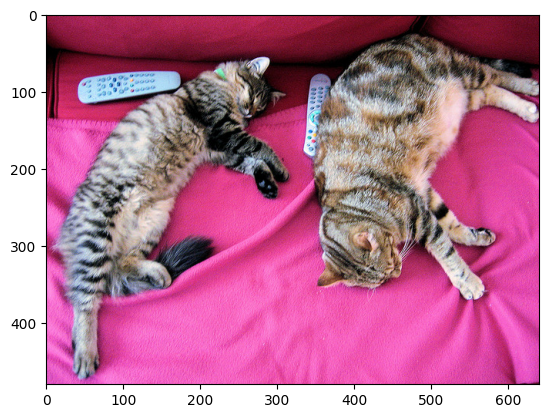

In [4]:
# Data Pipeline

## Installations
#!pip install datasets

## Imports
from datasets import load_dataset
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np

## Image from the COCO dataset
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
plt.imshow(np.array(image))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


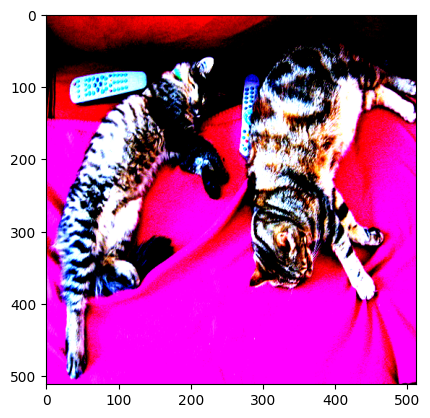

In [5]:
## Preprocessing image

image_preprocessed = image_processor(image, return_tensors="pt")
image_preprocessed_pixel_values = image_preprocessed['pixel_values']
plt.imshow(image_preprocessed_pixel_values[0].permute(1,2,0))

# Models

In this section, we will show some simple outputs of our SegFormer models to get a better understanding of our problem. Like the preprocessing step above, we simply feed the model checkpoint into pre-made segmentation and classification functions to retrieve the model. This can be seen below.

In [6]:
# SegFormer Models

## Installations
# !pip install transformers
# !pip install torch torchvision

## Imports
import torch
from torch import nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageNet
from transformers import SegformerForSemanticSegmentation, SegformerForImageClassification, AutoImageProcessor

## Segmentation and Classification Models

### Segmentation Model
seg_model = SegformerForSemanticSegmentation.from_pretrained(pretrained_checkpoint, num_labels = 10)

inputs = image_processor(images=image, return_tensors="pt")
outputs = seg_model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)
print('\n')
print(f'Shape of the raw segmentation model output: {logits.shape}')
upsampled_logits = nn.functional.interpolate(logits, size=(512, 512), mode='bilinear', align_corners=False)
print(f'Shape of the upsampled logits: {upsampled_logits.shape}')

print('\n')

### Classification Model
clf_model = SegformerForImageClassification.from_pretrained(pretrained_checkpoint)

inputs = image_processor(image, return_tensors="pt")

with torch.no_grad():
    logits = clf_model(**inputs).logits
print(f'Shape of the raw classification model output: {logits.shape}')

#### Getting the actual class
predicted_label = logits.argmax(-1).item()
print(f'Label corresponding to the argmax: {clf_model.config.id2label[predicted_label]}')

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.classifier.bias', 'decode_head.batch_norm.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.batch_norm.weight', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.




Shape of the raw segmentation model output: torch.Size([1, 10, 128, 128])
Shape of the upsampled logits: torch.Size([1, 10, 512, 512])


Shape of the raw classification model output: torch.Size([1, 1000])
Label corresponding to the argmax: tabby, tabby cat


We note two things here, namely the $10$ in the second place of the tensor output of the segmentation model. This is the number of labels we have it earlier. We also note that by default, the model outputs a tensor of the following shape: $(bs, n_l, \frac{height}{4}, \frac{width}{4})$. So, we must upsample to get a proper segmented image of the same size as the original.

Second, the warning telling us that the decoder is newly initialized in the segmentation model means we would need to train this to use it, but the encoder is fine-tuned.

# Supplementary Material

In this section, we thought it might be interesting to see the model structure for each. So, we have printed that out for the curious party.

In [22]:
seg_model

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [23]:
clf_model

SegformerForImageClassification(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
   